In [2]:
from binance.client import Client
import pandas as pd
from datetime import datetime
import time
from itertools import combinations
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import numpy as np
import statsmodels.api as sm
from talib.abstract import *
pd.options.display.max_rows = 20
import math

In [3]:
api_key = 'f348605e61f4109408560ae12b04392873d6c09b8061c849adc35d04431db50c'
api_secret = '1701ea99c6e8ddca3b610eb2fab39b8469f0550ca69b9389c25d730435d2d53d'


In [4]:
token1="EOSUSDT"
token2="NEOUSDT"
new_lvrg = int(1)
api_k = '4F2lU3qxemRNrpwykU9CHUxpXLhJ691A2h7q94FSZmuQEaOPmDoJFYk0MRfFY1aS'
api_s = 'bdgt258XuwGmkJd3LVcmbQZvHPVoNfvNSEB7uvgU4yyCb3I56pdXIR9d5CpYHUQt'
client = Client(api_k, api_s,testnet=False)
client.futures_change_leverage(symbol = token1,leverage=new_lvrg)
client.futures_change_leverage(symbol = token2,leverage=new_lvrg)

{'symbol': 'NEOUSDT', 'leverage': 1, 'maxNotionalValue': '30000000'}

In [5]:
df = pd.DataFrame(client.futures_ticker())
df = df.apply(lambda col:pd.to_numeric(col, errors='ignore'))
df = df.sort_values(by='quoteVolume',ascending=False)
ticker=[]
for i in range(len(df)):
    if('USDT'in df['symbol'].iloc[i]):
         if('_' not in df['symbol'].iloc[i]):
            ticker.append(df['symbol'].iloc[i])


In [6]:
def getBinanceDataFuture(symbol, interval, start, end, limit=5000):
    df = pd.DataFrame()
    startDate = end
    prev = start
    while (startDate!=prev):
        prev = startDate
        url = 'https://fapi.binance.com/fapi/v1/klines?symbol=' + \
            symbol + '&interval=' + interval + '&endTime=' + str(startDate) 

        df2 = pd.read_json(url)
        df2.columns = ['Opentime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Closetime', 'Quote asset volume', 'Number of trades','Taker by base', 'Taker buy quote', 'Ignore']
       
        df = pd.concat([df2, df], axis=0, ignore_index=True, keys=None)
        startDate = df.Opentime[0]
        
        
        
    df.reset_index(drop=True, inplace=True)  
    df['Opentime'] = pd.to_datetime(df['Opentime'],unit='ms')
    df = df.loc[1:]
    df = df[['Opentime', 'Open', 'High', 'Low', 'Close']]
    df = df.set_index('Opentime')
    df = df.drop_duplicates(keep=False)
    return df 

In [7]:
def current_milli_time():
    return round(time.time() * 1000)

In [8]:
data = pd.DataFrame()
c = 0
for i in ticker:
    temp = getBinanceDataFuture(i,'1d',1458955882,current_milli_time())
    data[i] = temp['Open']

data

KeyboardInterrupt: 

In [1]:
data

NameError: name 'data' is not defined

In [21]:
ticker=[]
for i in range(len(df)):
    if('USDT'in df['symbol'].iloc[i]):
         if('_' not in df['symbol'].iloc[i]):
            ticker.append(df['symbol'].iloc[i])
date = []
for i in ticker:
    date.append([data[i].first_valid_index(),i])
date= pd.DataFrame(date)

ticker = list(date[date[0]<"2020-03-01"][1])
ticker


['BTCUSDT',
 'ETHUSDT',
 'ADAUSDT',
 'ETCUSDT',
 'XRPUSDT',
 'BNBUSDT',
 'ATOMUSDT',
 'LINKUSDT',
 'LTCUSDT',
 'EOSUSDT',
 'ZECUSDT',
 'VETUSDT',
 'BCHUSDT',
 'IOSTUSDT',
 'TRXUSDT',
 'XTZUSDT',
 'XMRUSDT',
 'DASHUSDT',
 'XLMUSDT',
 'NEOUSDT',
 'QTUMUSDT',
 'BATUSDT',
 'IOTAUSDT',
 'ONTUSDT']

In [22]:

unwatnted = ["APEUSDT","BNXUSDT"]

ticker = [x for x in ticker if not x in unwatnted]

combo = list(combinations(ticker,2))
adfull = []
for i in range(len(combo)):
    if len(data[combo[i][0]].dropna())>len(data[combo[i][1]].dropna()):
        try:
            test= coint(data[combo[i][0]][data[combo[i][1]].dropna().index[0]:],data[combo[i][1]].dropna())[1]
            adfull.append([test,combo[i]])
        except:
            pass
    else:
        try:
            test= coint(data[combo[i][1]][data[combo[i][0]].dropna().index[0]:],data[combo[i][0]].dropna())[1]
            adfull.append([test,combo[i]])
        except:
            pass
result = pd.DataFrame(adfull,columns=["pvalue","pair"])
result.sort_values(by="pvalue").head(40)

,pvalue,pair
165,0.000191,"(LTCUSDT, XLMUSDT)"
66,0.000384,"(ETCUSDT, XRPUSDT)"
180,0.000691,"(EOSUSDT, NEOUSDT)"
46,0.001180,"(ADAUSDT, XRPUSDT)"
206,0.001331,"(VETUSDT, QTUMUSDT)"
...,...,...
131,0.032043,"(ATOMUSDT, XTZUSDT)"
96,0.032091,"(XRPUSDT, XTZUSDT)"
253,0.034222,"(XMRUSDT, IOTAUSDT)"
190,0.034227,"(ZECUSDT, XMRUSDT)"


In [9]:
def signalf(varaible,a,b):
    
    lookback,sdenter,sdexit,sdloss = varaible
    lookback = int(lookback)
    
    
    #merge data
    pairPrice = a.merge(b, left_index=True, right_index=True, how='left')
    pairPrice = pairPrice.dropna()

    reg = sm.OLS(pairPrice['Open_x'],pairPrice['Open_y']).fit()
    reg2 = sm.OLS(pairPrice['Open_y'],pairPrice['Open_x']).fit()
    
    #see which token should be a the dependent variable
    if adfuller(reg.resid)[1]<adfuller(reg2.resid)[1]:
        y = pairPrice['Open_x']
        x = pairPrice['Open_y']
        yfr = pairPrice['fr_x']
        xfr = pairPrice['fr_y']
        hedge = reg.params[0]
        spread = reg.resid
        y_name = str(a)
        x_name = str(b)
        
    else:
        y = pairPrice['Open_y']
        x = pairPrice['Open_x']
        xfr = pairPrice['fr_x']
        yfr = pairPrice['fr_y']
        hedge = reg2.params[0]
        spread = reg2.resid
        y_name = str(b)
        x_name = str(a)
    
    
   
    #creating bbands
    bands = pd.DataFrame(BBANDS(spread,timeperiod=lookback,nbdevup=sdenter,nbdevdn = sdenter,matype=1)).T
    bands = bands.set_index(pairPrice.index)
    bands.columns = ['Short','1mid','Long']

    bands2 = pd.DataFrame(BBANDS(spread,timeperiod=lookback,nbdevup=sdexit,nbdevdn = sdexit,matype=1)).T
    bands2 = bands2.set_index(pairPrice.index)
    bands2.columns = ['exShort','mid','exLong']

    bands3 = pd.DataFrame(BBANDS(spread,timeperiod=lookback,nbdevup=sdloss,nbdevdn = sdloss,matype=1)).T
    bands3 = bands3.set_index(pairPrice.index)
    bands3.columns = ['stShort','mid2','stLong']
    bbands = bands2.join(bands)
    bbands = bbands.join(bands3)
    bbands = bbands.drop(columns = ['mid','1mid','mid2'])
    
    bbands['y'] = y
    bbands['x'] = x
    bbands['spread'] = spread
    bbands['hedge'] =hedge
    bbands['xfr'] = xfr
    bbands['yfr'] = yfr

    bbands = bbands.dropna()
    
    #creating positions
    # bbands.loc[bbands['spread']>bbands['Short'],'position']=-1
    # bbands.loc[(bbands['spread']<bbands['exShort']) & (bbands['spread']>bbands['exLong']),'position']=0
    # bbands.loc[bbands['spread']<bbands['Long'],'position']=1
    # bbands.loc[(bbands["spread"]<bbands["stLong"]) | (bbands["spread"]>bbands["stShort"]),'position']=0
    # bbands = bbands.ffill()

    bbands.loc[bbands['spread']>bbands['Short'],'position']=-1
 
    bbands.loc[(bbands["position"]==-1) & (bbands["spread"]<bbands["exShort"]),'position']=0
    
    bbands.loc[bbands['spread']<bbands['Long'],'position']=1
    bbands.loc[(bbands["position"]==-1) & (bbands["spread"]<bbands["exShort"]),'position']=0
    
    bbands.loc[(bbands["position"]==1) & (bbands["spread"]>bbands["exLong"]),'position']=0
    bbands.loc[(bbands["spread"]<bbands["stLong"]) | (bbands["spread"]>bbands["stShort"]),'position']=0

    bbands = bbands.ffill()

   
    
    
    bbands['oposition'] = -1*bbands["position"]
    bbands = bbands.fillna(0)
    #creating size 
    bbands.loc[bbands['position'].diff()!=0,"ysize"] = bbands["y"]/(bbands["x"]*bbands["hedge"]+bbands["y"])
    bbands['xsize'] = 1-bbands['ysize']
    
    #creating the diff 
    bbands[['ydiff','xdiff']] = bbands[['y','x']].diff()
    bbands = bbands.ffill()
    

    
    return bbands,y_name,x_name

In [10]:
def signalfV2(varaible,a,b):
    
    lookback,sdenter,sdexit,sdloss = varaible
    lookback = int(lookback)
    
    
    #merge data
    pairPrice = a.merge(b, left_index=True, right_index=True, how='left')
    pairPrice = pairPrice.dropna()

    reg = sm.OLS(pairPrice['Open_x'],pairPrice['Open_y']).fit()
    reg2 = sm.OLS(pairPrice['Open_y'],pairPrice['Open_x']).fit()
    
    #see which token should be a the dependent variable
    if adfuller(reg.resid)[1]<adfuller(reg2.resid)[1]:
        y = pairPrice['Open_x']
        x = pairPrice['Open_y']
        yfr = pairPrice['fr_x']
        xfr = pairPrice['fr_y']
        hedge = reg.params[0]
        spread = reg.resid
        y_name = str(a)
        x_name = str(b)
        
    else:
        y = pairPrice['Open_y']
        x = pairPrice['Open_x']
        xfr = pairPrice['fr_x']
        yfr = pairPrice['fr_y']
        hedge = reg2.params[0]
        spread = reg2.resid
        y_name = str(b)
        x_name = str(a)
    
    
   
    #creating bbands
    bands = pd.DataFrame(BBANDS(spread,timeperiod=lookback,nbdevup=sdenter,nbdevdn = sdenter,matype=1)).T
    bands = bands.set_index(pairPrice.index)
    bands.columns = ['Short','1mid','Long']

    bands2 = pd.DataFrame(BBANDS(spread,timeperiod=lookback,nbdevup=sdexit,nbdevdn = sdexit,matype=1)).T
    bands2 = bands2.set_index(pairPrice.index)
    bands2.columns = ['exShort','mid','exLong']

    bands3 = pd.DataFrame(BBANDS(spread,timeperiod=lookback,nbdevup=sdloss,nbdevdn = sdloss,matype=1)).T
    bands3 = bands3.set_index(pairPrice.index)
    bands3.columns = ['stShort','mid2','stLong']
    bbands = bands2.join(bands)
    bbands = bbands.join(bands3)
    bbands = bbands.drop(columns = ['mid','1mid','mid2'])
    
    bbands['y'] = y
    bbands['x'] = x
    bbands['spread'] = spread
    bbands['hedge'] =hedge
    bbands['xfr'] = xfr
    bbands['yfr'] = yfr
    
    bbands[['ydiff','xdiff']] = bbands[['y','x']].diff()
    bbands = bbands.dropna()
    
    
    return bbands,y_name,x_name

In [11]:
def simulfV2(bbands):
    protfolio = []
    size = []
    fee = [] 
    cap = 1000
    position = np.array([0,0])

    for i in range(len(bbands)):
        #spread> short :
        if (position ==[0,0]).all():
            if (bbands["spread"].iloc[i]>bbands["Short"].iloc[i])&(bbands["spread"].iloc[i]<bbands["stShort"].iloc[i]):
                yp = bbands["y"].iloc[i]/(bbands["x"].iloc[i]*bbands["hedge"].iloc[i]+bbands["y"].iloc[i])
                xp = 1-yp
                position = np.array([-1*cap*yp/bbands['y'].iloc[i],1*cap*xp/bbands['x'].iloc[i]])
                commision = cap*((0.04/100))
                protfolio.append(cap)
                size.append(position)
                fee.append(commision)
                continue
                
            elif (bbands["spread"].iloc[i]<bbands["Long"].iloc[i]) & (bbands["spread"].iloc[i]>bbands["stLong"].iloc[i]):
                yp = bbands["y"].iloc[i]/(bbands["x"].iloc[i]*bbands["hedge"].iloc[i]+bbands["y"].iloc[i])
                xp = 1-yp
                position = np.array([1*cap*yp/bbands['y'].iloc[i],-1*cap*xp/bbands['x'].iloc[i]])
                commision = cap*((0.04/100))
                protfolio.append(cap)
                size.append(position)
                fee.append(commision)
                continue
            else:
                protfolio.append(cap)
                size.append(position)
                fee.append(0)
                continue
        elif (np.sign(position)==[-1,1]).all():
            if (bbands["spread"].iloc[i]<bbands["exShort"].iloc[i])|(bbands["spread"].iloc[i]>bbands["stShort"].iloc[i]):
                cap = cap + (position*np.array((bbands["ydiff"].iloc[i],bbands["xdiff"].iloc[i]))).sum()
                commision = cap*((0.04/100))
                position = np.array([0,0])
                protfolio.append(cap)
                size.append(position)
                fee.append(commision)
                continue
            else:
                cap = cap + (position*np.array((bbands["ydiff"].iloc[i],bbands["xdiff"].iloc[i]))).sum()
                long = position[1]*bbands["x"][i]
                short = cap- long
                fundingRate = short*bbands["yfr"][i]-long*bbands["xfr"][i]
                protfolio.append(cap)
                size.append(position)
                fee.append(fundingRate)
                continue
        else:
            if (bbands["spread"].iloc[i]>bbands["exLong"].iloc[i])|(bbands["spread"].iloc[i]<bbands["stLong"].iloc[i]):
                cap = cap + (position*np.array((bbands["ydiff"].iloc[i],bbands["xdiff"].iloc[i]))).sum()
                commision = cap*((0.04/100))
                position = np.array([0,0])
                protfolio.append(cap)
                size.append(position)
                fee.append(commision)
                continue
            else:
                cap = cap + (position*np.array((bbands["ydiff"].iloc[i],bbands["xdiff"].iloc[i]))).sum()
                long = position[0]*bbands["y"][i]
                short = cap- long
                fundingRate = short*bbands["xfr"][i]-long*bbands["yfr"][i]
                protfolio.append(cap)
                size.append(position)
                fee.append(fundingRate)
                continue

            
    bbands["portfolio"] = protfolio
    bbands[["y_size","x_size"]] = size

    
    bbands["fee"] = fee
    bbands["adjPortfolio"] = protfolio- bbands["fee"].cumsum()
    
    return bbands

In [12]:
[0.0,0]==[0,0]

True

In [13]:
def simulf(bbands):
    protfolio = []
    size = []
    fee = [] 
    cap = 1000
    position = np.array([0,0])

    for i in range(len(bbands)):
        if (bbands["position"].iloc[i]!=0):
            if (np.sign(position)!=list(bbands[["position","oposition"]].iloc[i])).all():
                position = np.array([bbands["position"].iloc[i]*cap*bbands["ysize"].iloc[i]/bbands['y'].iloc[i],bbands["oposition"].iloc[i]*cap*bbands["xsize"].iloc[i]/bbands['x'].iloc[i]])
                commision = cap*((0.04/100))
                protfolio.append(cap)
                size.append(position)
                fee.append(commision)
            else:
                cap = cap + (position*np.array((bbands["ydiff"].iloc[i],bbands["xdiff"].iloc[i]))).sum()
                if position[0]>0:
                    long = position[0]*bbands["y"][i]
                    short = cap- long
                    fundingRate = short*bbands["xfr"][i]-long*bbands["yfr"][i]
                else:
                    long = position[1]*bbands["x"][i]
                    short = cap- long
                    fundingRate = short*bbands["yfr"][i]-long*bbands["xfr"][i]
                protfolio.append(cap)
                size.append(position)
                fee.append(fundingRate)

        else:
            if (position!=[0,0]).all():
                cap = cap + (position*np.array((bbands["ydiff"].iloc[i],bbands["xdiff"].iloc[i]))).sum()
                commision = cap*((0.04/100))
                position = np.array([0,0])
                protfolio.append(cap)
                size.append(position)
                fee.append(commision)
            else:
                protfolio.append(cap)
                size.append(position)
                fee.append(0)
    bbands["portfolio"] = protfolio
    bbands[["y_size","x_size"]] = size

    
    bbands["fee"] = fee
    bbands["adjPortfolio"] = protfolio- bbands["fee"].cumsum()
    
    return bbands

In [14]:
def sharpe(bbands):
    try:
        bbands["pnl"] = bbands["adjPortfolio"].pct_change()
        sharpe = math.sqrt(len(bbands))*bbands["pnl"].mean()/bbands["pnl"].std()
    except :
        return 0
    return sharpe    

In [15]:
def getBinanceDataFundingRate(symbol, interval, start, end, limit=1000):
    df = pd.DataFrame()
    startDate = start
    prev = 0
    while (startDate!=prev):
        prev = startDate
        url = 'https://fapi.binance.com/fapi/v1/fundingRate?symbol=' + \
            symbol + '&startTime=' + str(startDate) + '&limit=' + str(limit)

        
        df2 = pd.read_json(url)
        df2.columns = ['symbol','fundingTime','fundingRate']
       
        df = pd.concat([df, df2], axis=0, ignore_index=True, keys=None)
        startDate = df2.fundingTime[len(df2)-1]
       
        
        
    df.reset_index(drop=True, inplace=True)  
    df['fundingTime'] = pd.to_datetime(df['fundingTime'],unit='ms')
    #df = df.loc[1:]
    #df = df.set_index('fundingTime')
    df = df.drop_duplicates(keep=False)
    df['fundingTime'] = df['fundingTime'].dt.floor('Min')
    df = df.set_index('fundingTime')
    return df 

In [16]:
def dataOrganizeDaily(ticker):
    fr =  getBinanceDataFundingRate(ticker,'1d',1458955882,current_milli_time())
    data = getBinanceDataFuture(ticker,'1d',1458955882,current_milli_time())
    date = fr.index.get_level_values('fundingTime').floor('D')
    dailyfr = fr.groupby([date]).sum().reset_index()
    dailyfr = dailyfr.set_index('fundingTime')
    data['fr'] = dailyfr['fundingRate']
    return data


In [17]:
def dataOrganizeHourly(ticker):
    fr =  getBinanceDataFundingRate(ticker,'1h',1458955882,current_milli_time())
    price = getBinanceDataFuture(ticker,'1h',1458955882,current_milli_time())
    data = convertFRhourly(fr,price)
    return data

In [18]:
def convertFRhourly(fr,price):
    fr["fundingRate"] = fr["fundingRate"]/8
    fr = fr.reindex(pd.date_range(price.index[0],price.index[-1],freq='1h'))
    fr = fr.ffill()
    price["fr"] = fr["fundingRate"]
    return price

In [19]:
x = dataOrganizeHourly('EOSUSDT')[24-8:]
y = dataOrganizeHourly('NEOUSDT')[24-8:]

In [366]:
xD = dataOrganizeDaily('EOSUSDT')[1:]
yD = dataOrganizeDaily('NEOUSDT')[1:]

In [20]:
xrp = dataOrganizeHourly('XRPUSDT')
trx = dataOrganizeHourly('TRXUSDT')

In [495]:
a = signalfV2([61*24,1.50,0.0,2.55],xrp,trx)[0].iloc[-1]
a

exShort     0.068080
exLong      0.068080
Short       0.124613
Long        0.011548
stShort     0.164186
stLong     -0.028025
y           0.773500
x           0.063650
spread      0.071791
hedge      11.024500
xfr         0.000013
yfr         0.000013
ydiff       0.009600
xdiff       0.000740
Name: 2022-04-08 15:00:00, dtype: float64

In [496]:
a["spread"]

0.07179054622232894

<AxesSubplot:xlabel='Opentime'>

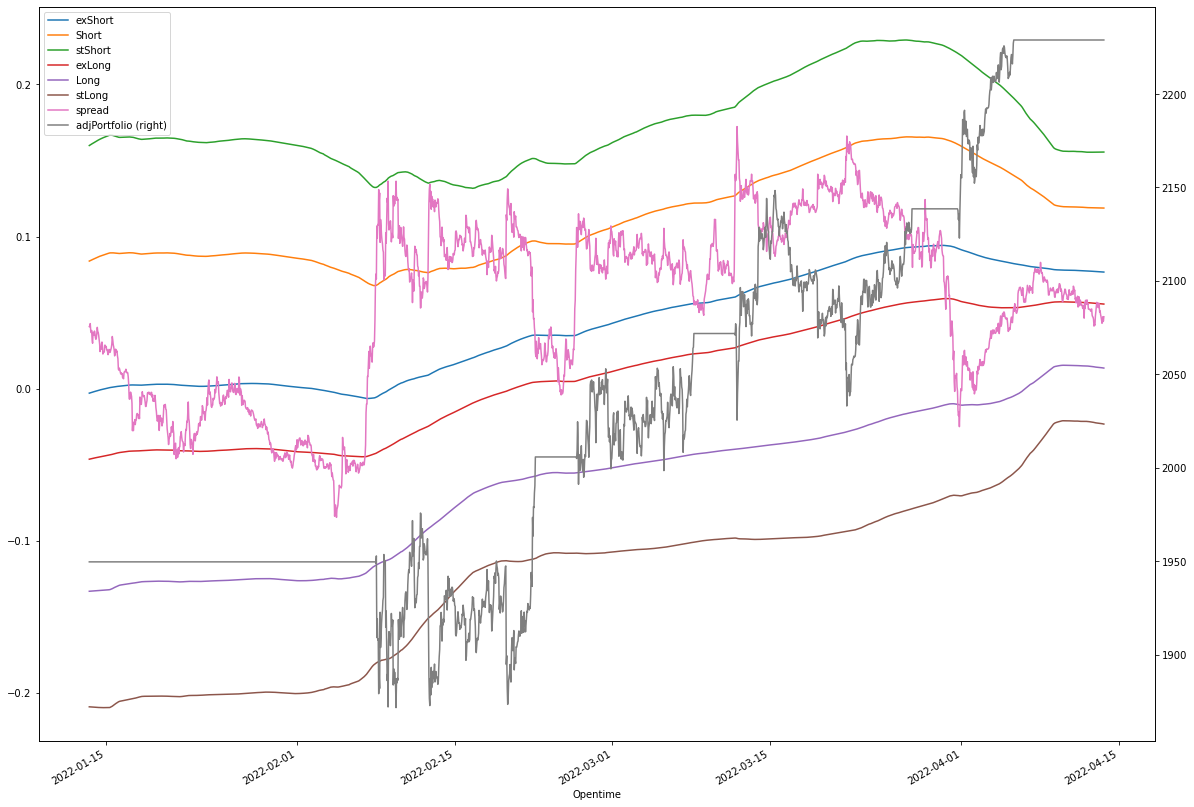

In [27]:
simulfV2(signalfV2([61*24,1.50,0.3,2.55],xrp,trx)[0]).tail(24*90).plot(y=["exShort","Short","stShort","exLong","Long","stLong","spread","adjPortfolio"],figsize = (20,15),secondary_y = "adjPortfolio")

In [306]:
ma= np.linspace(300,10,7)
enter = np.linspace(3,0,6)
exit = np.linspace(1,0,6)
loss = np.linspace(5,0,6)
combo = []
for i in range(len(ma)):
    for j in range(len(enter)):
        for k in range(len(exit)): 
            for l in range(len(loss)): 
                if (loss[l]>enter[j]>exit[k]) :
                    combo.append([round(ma[i]),round(enter[j],2),round(exit[k],2),round(loss[l],2)])
len(combo)

686

In [450]:
%%time

result = []
for i in combo:
    #result.append((i,(simulf(signalf(i,x,y)[0])['adjPortfolio'].iloc[-1])))
    result.append((i,sharpe(simulfV2(signalfV2(i,xD,yD)[0]))))
result = pd.DataFrame(result).sort_values(by= 1,ascending=False)
result.head(20)

KeyboardInterrupt: 

In [309]:
sharpe(simulfV2(signalfV2([155.0, 0.5, 0.33333333333333337, 1.0],xD,yD)[0]))

3.414991898279539

<AxesSubplot:xlabel='Opentime'>

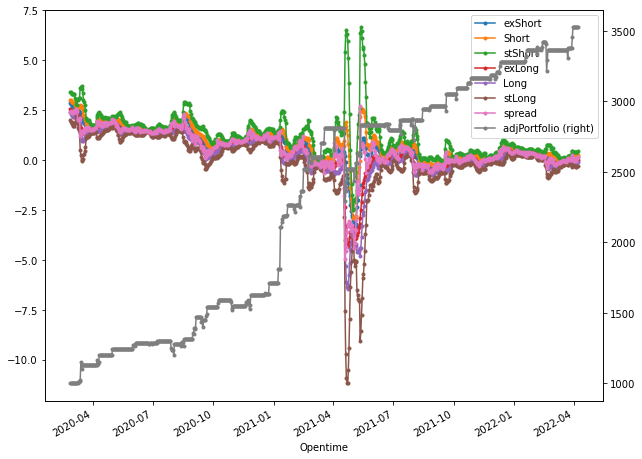

In [368]:
#simulf(signalf([240, 1.8, 0.8, 4.0],x,y)[0]).plot(y=["exShort","Short","stShort","exLong","Long","stLong","spread","adjPortfolio"],figsize = (10,8),secondary_y = "adjPortfolio",style='.-')

simulfV2(signalfV2([10, 1.8, 0.8, 4.0],xD,yD)[0]).plot(y=["exShort","Short","stShort","exLong","Long","stLong","spread","adjPortfolio"],figsize = (10,8),secondary_y = "adjPortfolio",style='.-')

<AxesSubplot:xlabel='Opentime'>

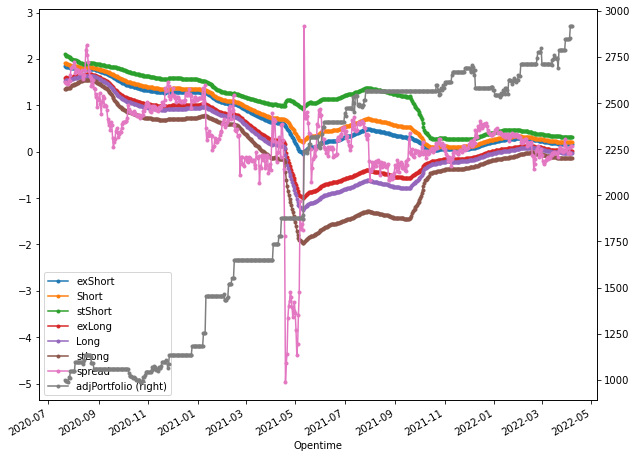

In [371]:
simulfV2(signalfV2(	[155.0, 0.5, 0.33333333333333337, 1.0],xD,yD)[0]).plot(y=["exShort","Short","stShort","exLong","Long","stLong","spread","adjPortfolio"],figsize = (10,8),secondary_y = "adjPortfolio",style='.-')

<AxesSubplot:xlabel='Opentime'>

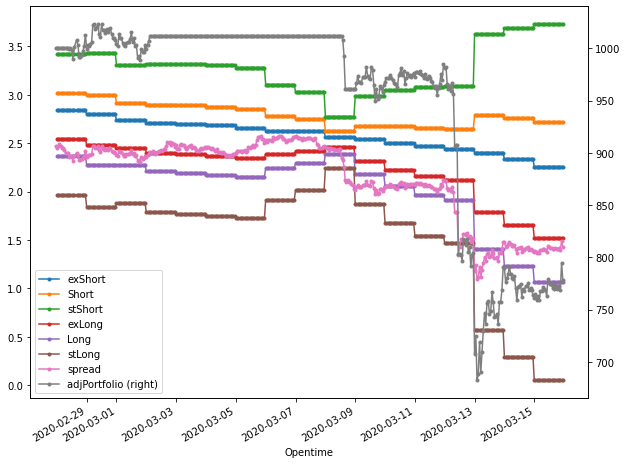

In [357]:
simulfV2(test)[:"2020-03-15"].plot(y=["exShort","Short","stShort","exLong","Long","stLong","spread","adjPortfolio"],figsize = (10,8),secondary_y = "adjPortfolio",style='.-')

In [339]:
day = signalfV2([10, 1.8, 0.8, 4.0],xD,yD)[0].iloc[:,:6]
day

,exShort,exLong,Short,Long,stShort,stLong
Opentime,,,,,,
2020-02-28,2.836649,2.546085,3.018252,2.364482,3.417779,1.964955
2020-02-29,2.795285,2.477084,2.994161,2.278209,3.431687,1.840683
2020-03-01,2.736528,2.450350,2.915388,2.271490,3.308882,1.877996
2020-03-02,2.706829,2.400680,2.898171,2.209338,3.319125,1.788384
2020-03-03,2.695988,2.386580,2.889368,2.193200,3.314804,1.767765
...,...,...,...,...,...,...
2022-04-03,0.102638,-0.033578,0.187773,-0.118712,0.375070,-0.306009
2022-04-04,0.095034,-0.044195,0.182053,-0.131214,0.373494,-0.322655
2022-04-05,0.110837,-0.031347,0.199703,-0.120213,0.395207,-0.315717


In [350]:
hour = signalfV2([240, 2.0, 0.8,4.0],x,y)[0].iloc[:,6:]
hour

,y,x,spread,hedge,xfr,yfr,ydiff,xdiff
Opentime,,,,,,,,
2020-02-27 23:00:00,3.623,11.330,2.465833,0.102133,0.000013,0.000013,0.044,0.123
2020-02-28 00:00:00,3.620,11.505,2.444959,0.102133,0.000013,0.000013,-0.003,0.175
2020-02-28 01:00:00,3.647,11.500,2.472470,0.102133,0.000013,0.000013,0.027,-0.005
2020-02-28 02:00:00,3.678,11.639,2.489274,0.102133,0.000013,0.000013,0.031,0.139
2020-02-28 03:00:00,3.652,11.535,2.473895,0.102133,0.000013,0.000013,-0.026,-0.104
...,...,...,...,...,...,...,...,...
2022-04-07 18:00:00,2.491,23.129,0.128765,0.102133,0.000013,0.000004,-0.004,0.070
2022-04-07 19:00:00,2.507,23.174,0.140169,0.102133,0.000013,0.000004,0.016,0.045
2022-04-07 20:00:00,2.504,23.055,0.149323,0.102133,0.000013,0.000004,-0.003,-0.119


In [351]:
test = hour.merge(day, left_index=True, right_index=True, how='left').ffill()
test

,y,x,spread,hedge,xfr,yfr,ydiff,xdiff,exShort,exLong,Short,Long,stShort,stLong
Opentime,,,,,,,,,,,,,,
2020-02-27 23:00:00,3.623,11.330,2.465833,0.102133,0.000013,0.000013,0.044,0.123,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-28 00:00:00,3.620,11.505,2.444959,0.102133,0.000013,0.000013,-0.003,0.175,2.836649,2.546085,3.018252,2.364482,3.417779,1.964955
2020-02-28 01:00:00,3.647,11.500,2.472470,0.102133,0.000013,0.000013,0.027,-0.005,2.836649,2.546085,3.018252,2.364482,3.417779,1.964955
2020-02-28 02:00:00,3.678,11.639,2.489274,0.102133,0.000013,0.000013,0.031,0.139,2.836649,2.546085,3.018252,2.364482,3.417779,1.964955
2020-02-28 03:00:00,3.652,11.535,2.473895,0.102133,0.000013,0.000013,-0.026,-0.104,2.836649,2.546085,3.018252,2.364482,3.417779,1.964955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-07 18:00:00,2.491,23.129,0.128765,0.102133,0.000013,0.000004,-0.004,0.070,0.137396,-0.004924,0.226346,-0.093873,0.422036,-0.289563
2022-04-07 19:00:00,2.507,23.174,0.140169,0.102133,0.000013,0.000004,0.016,0.045,0.137396,-0.004924,0.226346,-0.093873,0.422036,-0.289563
2022-04-07 20:00:00,2.504,23.055,0.149323,0.102133,0.000013,0.000004,-0.003,-0.119,0.137396,-0.004924,0.226346,-0.093873,0.422036,-0.289563


In [352]:
simulfV2(test)

,y,x,spread,hedge,xfr,yfr,ydiff,xdiff,exShort,exLong,Short,Long,stShort,stLong,portfolio,y_size,x_size,fee,adjPortfolio
Opentime,,,,,,,,,,,,,,,,,,,
2020-02-27 23:00:00,3.623,11.330,2.465833,0.102133,0.000013,0.000013,0.044,0.123,NaN,NaN,NaN,NaN,NaN,NaN,1000.000000,0.0,0.0,0.0,1000.000000
2020-02-28 00:00:00,3.620,11.505,2.444959,0.102133,0.000013,0.000013,-0.003,0.175,2.836649,2.546085,3.018252,2.364482,3.417779,1.964955,1000.000000,0.0,0.0,0.0,1000.000000
2020-02-28 01:00:00,3.647,11.500,2.472470,0.102133,0.000013,0.000013,0.027,-0.005,2.836649,2.546085,3.018252,2.364482,3.417779,1.964955,1000.000000,0.0,0.0,0.0,1000.000000
2020-02-28 02:00:00,3.678,11.639,2.489274,0.102133,0.000013,0.000013,0.031,0.139,2.836649,2.546085,3.018252,2.364482,3.417779,1.964955,1000.000000,0.0,0.0,0.0,1000.000000
2020-02-28 03:00:00,3.652,11.535,2.473895,0.102133,0.000013,0.000013,-0.026,-0.104,2.836649,2.546085,3.018252,2.364482,3.417779,1.964955,1000.000000,0.0,0.0,0.0,1000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-07 18:00:00,2.491,23.129,0.128765,0.102133,0.000013,0.000004,-0.004,0.070,0.137396,-0.004924,0.226346,-0.093873,0.422036,-0.289563,1450.451109,0.0,0.0,0.0,1242.788552
2022-04-07 19:00:00,2.507,23.174,0.140169,0.102133,0.000013,0.000004,0.016,0.045,0.137396,-0.004924,0.226346,-0.093873,0.422036,-0.289563,1450.451109,0.0,0.0,0.0,1242.788552
2022-04-07 20:00:00,2.504,23.055,0.149323,0.102133,0.000013,0.000004,-0.003,-0.119,0.137396,-0.004924,0.226346,-0.093873,0.422036,-0.289563,1450.451109,0.0,0.0,0.0,1242.788552


In [347]:
simulfV2(signalfV2([10, 1.8, 0.8, 4.0],xD,yD)[0])

,exShort,exLong,Short,Long,stShort,stLong,y,x,spread,hedge,xfr,yfr,ydiff,xdiff,portfolio,y_size,x_size,fee,adjPortfolio
Opentime,,,,,,,,,,,,,,,,,,,
2020-02-27,2.853626,2.578512,3.025572,2.406565,3.403854,2.028283,3.539,10.999,2.415053,0.102186,0.0003,0.000300,-0.542,-1.401,1000.000000,0.0,0.0,0.0,1000.000000
2020-02-28,2.814884,2.518446,3.000158,2.333172,3.407761,1.925569,3.620,11.505,2.444347,0.102186,0.0003,0.000395,0.081,0.506,1000.000000,0.0,0.0,0.0,1000.000000
2020-02-29,2.749948,2.471967,2.923685,2.298229,3.305909,1.916006,3.516,11.310,2.360273,0.102186,0.0003,0.000552,-0.104,-0.195,1000.000000,0.0,0.0,0.0,1000.000000
2020-03-01,2.718409,2.419416,2.905281,2.232545,3.316397,1.821428,3.515,11.110,2.379711,0.102186,0.0003,0.000883,-0.001,-0.200,1000.000000,0.0,0.0,0.0,1000.000000
2020-03-02,2.690607,2.369552,2.891266,2.168893,3.332717,1.727443,3.513,11.329,2.355332,0.102186,0.0003,0.000570,-0.002,0.219,1000.000000,0.0,0.0,0.0,1000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-03,0.105832,-0.035546,0.194193,-0.123907,0.388587,-0.318301,2.787,27.572,-0.030479,0.102186,0.0003,0.000300,-0.050,-0.470,3638.891942,0.0,0.0,0.0,3525.453756
2022-04-04,0.098105,-0.047920,0.189371,-0.139185,0.390155,-0.339970,2.842,28.009,-0.020135,0.102186,0.0003,0.000300,0.055,0.437,3638.891942,0.0,0.0,0.0,3525.453756
2022-04-05,0.115201,-0.033641,0.208228,-0.126668,0.412886,-0.331326,2.889,27.182,0.111373,0.102186,0.0003,0.000300,0.047,-0.827,3638.891942,0.0,0.0,0.0,3525.453756


In [364]:
from datetime import date

datetime.now()

datetime.datetime(2022, 4, 7, 19, 19, 36, 754436)

<AxesSubplot:xlabel='Opentime'>

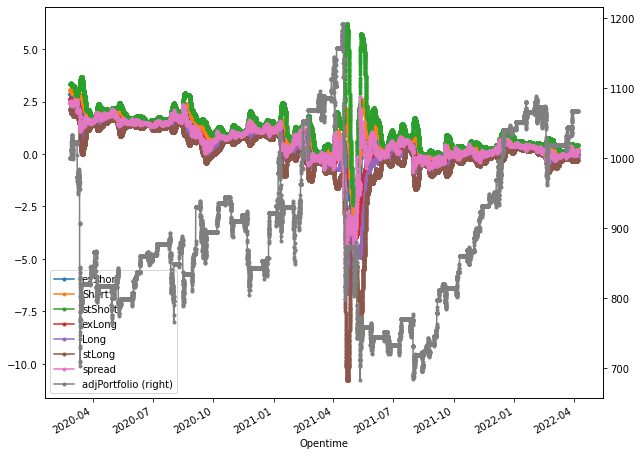

In [265]:
simulfV2(signalfV2([240, 2.0, 0.8,4.0],x,y)[0]).plot(y=["exShort","Short","stShort","exLong","Long","stLong","spread","adjPortfolio"],figsize = (10,8),secondary_y = "adjPortfolio",style='.-')

In [239]:
result.head(40)

,0,1
717,"[155.0, 0.5, 0.33333333333333337, 1.0]",3.554204
724,"[155.0, 0.5, 0.16666666666666674, 1.0]",3.503384
731,"[155.0, 0.5, 0.0, 1.0]",3.353765
351,"[251.66666666666666, 0.5, 0.33333333333333337,...",3.150128
175,"[300.0, 0.5, 0.16666666666666674, 1.0]",3.110252
1156,"[10.0, 2.0, 0.8333333333333334, 2.333333333333...",3.060969
174,"[300.0, 0.5, 0.16666666666666674, 1.6666666666...",3.054148
1161,"[10.0, 2.0, 0.6666666666666667, 2.333333333333...",3.031159
350,"[251.66666666666666, 0.5, 0.33333333333333337,...",2.983685
348,"[251.66666666666666, 0.5, 0.33333333333333337,...",2.971665


In [49]:
result = pd.DataFrame(result).sort_values(by= 1,ascending=False)
result.head(20)

,0,1
984,"[30.0, 1.4, 0.1, 4.183333333333334]",6195.413196
985,"[30.0, 1.4, 0.1, 3.3666666666666663]",6065.706550
986,"[30.0, 1.4, 0.1, 2.55]",6035.350832
995,"[30.0, 0.75, 0.1, 4.183333333333334]",5277.728883
996,"[30.0, 0.75, 0.1, 3.3666666666666663]",4880.622866
997,"[30.0, 0.75, 0.1, 2.55]",4650.205615
895,"[82.22222222222223, 0.75, 0.1, 4.183333333333334]",4189.367301
983,"[30.0, 1.4, 0.1, 5.0]",3713.034956
975,"[30.0, 1.4, 1.0666666666666667, 3.366666666666...",3698.305315
894,"[82.22222222222223, 0.75, 0.1, 5.0]",3532.575808


In [142]:
pd.options.display.max_rows = 50
pd.set_option('display.max_columns', 500)
simulf(signalf([30.0, 1.4, 0.1, 4.183333333333334],xD,yD)[0])["2020-04-30":"2020-07-30"].head(30)

,exShort,exLong,Short,Long,stShort,stLong,y,x,spread,hedge,xfr,yfr,position,oposition,ysize,xsize,ydiff,xdiff,portfolio,y_size,x_size,fee,adjPortfolio
Opentime,,,,,,,,,,,,,,,,,,,,,,,
2020-03-17,2.367965,2.269025,3.011075,1.625914,4.387991,0.248998,1.893,5.379,1.343117,0.102228,0.000300,0.000300,1.0,-1.0,0.774904,0.225096,NaN,NaN,1000.0,409.352378,-41.847174,0.4,999.6
2020-03-18,2.309608,2.208026,2.969890,1.547743,4.383573,0.134061,1.968,5.620,1.393480,0.102228,0.000300,0.000300,1.0,-1.0,0.774904,0.225096,0.075,0.241,1000.0,393.752059,-40.052660,0.4,999.2
2020-03-19,2.256342,2.152495,2.931344,1.477492,4.376542,0.032294,2.001,5.726,1.415644,0.102228,0.000300,0.000397,1.0,-1.0,0.774904,0.225096,0.033,0.106,1000.0,387.258396,-39.311203,0.4,998.8
2020-03-20,2.217542,2.115664,2.879751,1.453455,4.297556,0.035650,2.280,6.473,1.618280,0.102228,0.000300,0.000752,1.0,-1.0,0.774904,0.225096,0.279,0.747,1000.0,339.870198,-34.774594,0.4,998.4
2020-03-21,2.179391,2.076190,2.850193,1.405388,4.286398,-0.030817,2.207,6.280,1.565010,0.102228,0.000300,0.000300,1.0,-1.0,0.774904,0.225096,-0.073,-0.193,1000.0,351.111940,-35.843304,0.4,998.0
2020-03-22,2.147911,2.044420,2.820603,1.371729,4.260852,-0.068520,2.275,6.235,1.637610,0.102228,0.000300,0.000498,1.0,-1.0,0.774904,0.225096,0.068,-0.045,1000.0,340.617165,-36.101997,0.4,997.6
2020-03-23,2.111555,2.007826,2.785793,1.333587,4.229355,-0.109975,2.137,5.930,1.530789,0.102228,0.000300,0.000300,1.0,-1.0,0.774904,0.225096,-0.138,-0.305,1000.0,362.613033,-37.958845,0.4,997.2
2020-03-24,2.081491,1.979129,2.746847,1.313773,4.171390,-0.110770,2.288,6.688,1.604301,0.102228,0.000300,0.000300,1.0,-1.0,0.774904,0.225096,0.151,0.758,1000.0,338.681841,-33.656691,0.4,996.8
2020-03-25,2.054144,1.956274,2.690298,1.320120,4.052320,-0.041902,2.346,6.894,1.641242,0.102228,0.000144,0.000300,1.0,-1.0,0.774904,0.225096,0.058,0.206,1000.0,330.308632,-32.650993,0.4,996.4


In [165]:
simulf(signalf([30.0, 1.4, 0.1, 4.183333333333334],xD,yD)[0])

,exShort,exLong,Short,Long,stShort,stLong,y,x,spread,hedge,xfr,yfr,position,oposition,ysize,xsize,ydiff,xdiff,portfolio,y_size,x_size,fee,adjPortfolio
Opentime,,,,,,,,,,,,,,,,,,,,,,,
2020-03-17,2.367965,2.269025,3.011075,1.625914,4.387991,0.248998,1.893,5.379,1.343117,0.102228,0.0003,0.000300,1.0,-1.0,0.774904,0.225096,NaN,NaN,1000.000000,409.352378,-41.847174,0.400000,999.600000
2020-03-18,2.309608,2.208026,2.969890,1.547743,4.383573,0.134061,1.968,5.620,1.393480,0.102228,0.0003,0.000300,1.0,-1.0,0.774904,0.225096,0.075,0.241,1020.616259,409.352378,-41.847174,-0.177178,1020.393438
2020-03-19,2.256342,2.152495,2.931344,1.477492,4.376542,0.032294,2.001,5.726,1.415644,0.102228,0.0003,0.000397,1.0,-1.0,0.774904,0.225096,0.033,0.106,1029.689087,409.352378,-41.847174,-0.262032,1029.728298
2020-03-20,2.217542,2.115664,2.879751,1.453455,4.297556,0.035650,2.280,6.473,1.618280,0.102228,0.0003,0.000752,1.0,-1.0,0.774904,0.225096,0.279,0.747,1112.638562,409.352378,-41.847174,-0.648354,1113.326127
2020-03-21,2.179391,2.076190,2.850193,1.405388,4.286398,-0.030817,2.207,6.280,1.565010,0.102228,0.0003,0.000300,1.0,-1.0,0.774904,0.225096,-0.073,-0.193,1090.832343,409.352378,-41.847174,-0.214815,1091.734722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-02,0.025682,0.004448,0.163706,-0.133576,0.459219,-0.429089,2.837,28.042,-0.029671,0.102228,0.0003,0.000300,-1.0,1.0,0.524708,0.475292,0.010,1.116,2247.200786,-390.839914,39.954686,0.001915,2245.990435
2022-04-03,0.021822,0.002283,0.148825,-0.124719,0.420741,-0.396635,2.787,27.572,-0.031624,0.102228,0.0003,0.000300,-1.0,1.0,0.524708,0.475292,-0.050,-0.470,2247.964079,-390.839914,39.954686,0.013411,2246.740317
2022-04-04,0.019137,0.000665,0.139209,-0.119407,0.396285,-0.376483,2.842,28.009,-0.021297,0.102228,0.0003,0.000300,-1.0,1.0,0.524708,0.475292,0.055,0.437,2243.928082,-390.839914,39.954686,0.001724,2242.702596


In [124]:
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()
top100= []
for i in cg.get_coins_markets('usd')[:130]:
    top100.append(i['id'])

In [105]:
combo = list(combinations(ticker,2))
adfull = []
for i in range(len(combo)):
    if len(data[combo[i][0]].dropna())>len(data[combo[i][1]].dropna()):
        try:
            test= coint(data[combo[i][0]][data[combo[i][1]].dropna().index[0]:],data[combo[i][1]].dropna())[1]
            adfull.append([test,combo[i]])
        except:
            pass
    else:
        try:
            test= coint(data[combo[i][1]][data[combo[i][0]].dropna().index[0]:],data[combo[i][0]].dropna())[1]
            adfull.append([test,combo[i]])
        except:
            pass
result = pd.DataFrame(adfull,columns=["pvalue","pair"])
result.sort_values(by="pvalue").head(30)

940

In [118]:
result.sort_values(by="pvalue").head(30)

,pvalue,pair
3037,0.000000e+00,"(BNXUSDT, KAVAUSDT)"
3020,0.000000e+00,"(BNXUSDT, IMXUSDT)"
3024,0.000000e+00,"(BNXUSDT, XLMUSDT)"
3030,0.000000e+00,"(BNXUSDT, ANTUSDT)"
3062,0.000000e+00,"(BNXUSDT, OCEANUSDT)"
3075,0.000000e+00,"(BNXUSDT, MTLUSDT)"
1106,0.000000e+00,"(DOGEUSDT, BNXUSDT)"
3080,1.343553e-29,"(BNXUSDT, LPTUSDT)"
2973,3.267895e-26,"(BNXUSDT, AAVEUSDT)"
3022,8.541356e-20,"(BNXUSDT, ANCUSDT)"


In [101]:
coint(data["BTCUSDT"][data["ETHUSDT"].dropna().index[0]:],data["ETHUSDT"].dropna())

,BTCUSDT,GMTUSDT
Opentime,,
2022-03-15,39651.6,0.32230
2022-03-16,39270.9,0.33111
2022-03-17,41105.9,0.55501
2022-03-18,40898.0,0.83013
2022-03-19,41751.6,0.69823
2022-03-20,42188.2,0.67149
2022-03-21,41261.0,0.57809
2022-03-22,40982.0,0.79703
2022-03-23,42349.9,0.80516


In [100]:
data["BTCUSDT"][data["ETHUSDT"].dropna().index[0]:]

Opentime
2019-11-27     7149.97
2019-11-28     7506.78
2019-11-29     7417.00
2019-11-30     7737.23
2019-12-01     7541.08
                ...   
2022-04-01    45505.90
2022-04-02    46266.20
2022-04-03    45792.30
2022-04-04    46392.30
2022-04-05    46580.90
Name: BTCUSDT, Length: 860, dtype: float64